In [89]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import recall_score, f1_score
from sklearn.metrics import precision_score, matthews_corrcoef, average_precision_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.pipeline import Pipeline


from sklearn.linear_model import LogisticRegression
from scipy.stats import chi2_contingency

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC

from imblearn.over_sampling import SMOTE

import lightgbm as lgb
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, matthews_corrcoef, average_precision_score, confusion_matrix, precision_score, recall_score, f1_score
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder

In [3]:
# Read in the cleaned dataset

df = pd.read_csv('cleaned_patient_data.csv')
df.head()

,Year,Gender,Age,Location,Race : African American,Race : Asian,Race : Caucasian,Race : Hispanic,Race : Other,Hypertension,...,Smoking History,BMI,HbA1c Level,Blood Glucose Level,Diabetes,Combined Risk Factors,BMI_Category,Blood_Glucose_Category,HbA1c_Category,Cluster
0,2020,Female,32.0,Alabama,0,0,0,0,1,0,...,never,27.32,5.0,100,0,0,Overweight,Prediabetes,Normal,1
1,2015,Female,29.0,Alabama,0,1,0,0,0,0,...,never,19.95,5.0,90,0,0,Normal weight,Normal,Normal,1
2,2015,Male,18.0,Alabama,0,0,0,0,1,0,...,never,23.76,4.8,160,0,0,Normal weight,Diabetes,Normal,3
3,2015,Male,41.0,Alabama,0,0,1,0,0,0,...,never,27.32,4.0,159,0,0,Overweight,Diabetes,Normal,3
4,2016,Female,52.0,Alabama,1,0,0,0,0,0,...,never,23.75,6.5,90,0,0,Normal weight,Normal,Diabetes,1


In [5]:
df.columns

Index(['Year', 'Gender', 'Age', 'Location', 'Race : African American',
       'Race : Asian', 'Race : Caucasian', 'Race : Hispanic', 'Race : Other',
       'Hypertension', 'Heart Disease', 'Smoking History', 'BMI',
       'HbA1c Level', 'Blood Glucose Level', 'Diabetes',
       'Combined Risk Factors', 'BMI_Category', 'Blood_Glucose_Category',
       'HbA1c_Category', 'Cluster'],
      dtype='object')

In [7]:
# Logistic Regression with 'balanced' class_weights

# Create a `LogisticRegression` function
lr_model = LogisticRegression(max_iter=500, random_state=99, class_weight='balanced')

dropped_df = df.drop(columns=['Location', 'Year'], axis=1)

# Get our target feature

X = dropped_df.drop(columns='Diabetes')
y = df['Diabetes']

# Split the data into training and testing sets before encoding
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=44)

# Perform one-hot encoding 
ohe = OneHotEncoder(drop='if_binary', dtype='int', sparse_output=False, handle_unknown='ignore')
X_train_encoded = ohe.fit_transform(X_train)
X_test_encoded = ohe.transform(X_test)

# Fit the model on the encoded training data
lr_model.fit(X_train_encoded, y_train)

# Make predictions on the test data
test_predictions = lr_model.predict(X_test_encoded)

# Save both the test predictions and actual test values to a DataFrame
results_df = pd.DataFrame({"Predictions": test_predictions, "Actual": y_test})

# Calculate the model's accuracy on the test dataset
accuracy = accuracy_score(y_test, test_predictions)

print(f"Model Accuracy: {accuracy:.2f}")

c:\Users\16148\anaconda3\envs\dev\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Model Accuracy: 0.92


In [8]:
# Create X  and y
# Drop Location and Year (Uninformative)

X = df.drop(columns=['Diabetes', 'Location', 'Year'], axis=1)
y = df['Diabetes']

# Create train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=11)

print(f"X_train shape : {X_train.shape}")
print(f"X_test shape:{X_test.shape}")

X_train shape : (74989, 18)
X_test shape:(24997, 18)


In [30]:
df.columns

Index(['Year', 'Gender', 'Age', 'Location', 'Race : African American',
       'Race : Asian', 'Race : Caucasian', 'Race : Hispanic', 'Race : Other',
       'Hypertension', 'Heart Disease', 'Smoking History', 'BMI',
       'HbA1c Level', 'Blood Glucose Level', 'Diabetes',
       'Combined Risk Factors', 'BMI_Category', 'Blood_Glucose_Category',
       'HbA1c_Category', 'Cluster'],
      dtype='object')

In [33]:
def evaluate_model(X_train, y_train, X_test, y_test, model, features):
    """
    Takes in X_train, X_test, y_train, y_test, the model to be evaluated,
    and the current feature list.
    Sort features into appropriate lists for preprocessing
    Returns scores
    """
    # Filter X_train and X_test to include only the specified features
    X_train_filtered = X_train[features]
    X_test_filtered = X_test[features]
    features = features

    
    # Define our feature lists for preprocessing
    features_to_scale = ['Age', 'BMI', 'HbA1c Level', 'Blood Glucose Level']
    features_to_ord = ['Smoking History', 'BMI_Category', 'Blood_Glucose_Category', 'HbA1c_Category']
    features_to_onehot = ['Gender']
    features_to_pass = ['Race : African American', 'Race : Asian', 'Race : Caucasian', 'Race : Hispanic',
                        'Race : Other', 'Hypertension', 'Heart Disease', 'Combined Risk Factors', 'Cluster']

    # Remove features not present in the current feature set
    features_to_scale = [f for f in features_to_scale if f in features]
    features_to_ord = [f for f in features_to_ord if f in features]
    features_to_onehot = [f for f in features_to_onehot if f in features]
    features_to_pass = [f for f in features_to_pass if f in features]

    # Define categories for ordinal encoding
    bmi_categories = ['Underweight', 'Normal weight', 'Overweight', 'Obese']
    glucose_hba1c_categories = ['Normal', 'Prediabetes', 'Diabetes']
    smoking_categories = ['No Info', 'never', 'former', 'not current', 'current', 'ever']

    # Define the preprocessing steps
    preprocessing_steps = []

    if features_to_scale:
        preprocessing_steps.append(('scaler', StandardScaler(), features_to_scale))
    
    if features_to_onehot:
        preprocessing_steps.append(('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), features_to_onehot))

    if 'BMI_Category' in features_to_ord:
        preprocessing_steps.append(('ordinal_bmi', OrdinalEncoder(categories=[bmi_categories], handle_unknown='use_encoded_value', unknown_value=-1), ['BMI_Category']))
    
    if 'Blood_Glucose_Category' in features_to_ord:
        preprocessing_steps.append(('ordinal_glucose', OrdinalEncoder(categories=[glucose_hba1c_categories], handle_unknown='use_encoded_value', unknown_value=-1), ['Blood_Glucose_Category']))
    
    if 'HbA1c_Category' in features_to_ord:
        preprocessing_steps.append(('ordinal_hba1c', OrdinalEncoder(categories=[glucose_hba1c_categories], handle_unknown='use_encoded_value', unknown_value=-1), ['HbA1c_Category']))
    
    if 'Smoking History' in features_to_ord:
        preprocessing_steps.append(('ordinal_smoking', OrdinalEncoder(categories=[smoking_categories], handle_unknown='use_encoded_value', unknown_value=-1), ['Smoking History']))

    # Define the Pipeline
    pipeline = Pipeline([
        ('preprocessor', ColumnTransformer(preprocessing_steps, remainder='passthrough')),
        ('classifier', model)
    ])

    # Fit the Pipeline
    pipeline.fit(X_train_filtered, y_train)

    # Make predictions
    y_train_pred = pipeline.predict(X_train_filtered)
    y_test_pred = pipeline.predict(X_test_filtered)
    
    # Create scoring dict, calculate scores
    scoring_dict = {
    'train_accuracy': accuracy_score(y_train, y_train_pred),
    'test_accuracy': accuracy_score(y_test, y_test_pred),
    'mcc': matthews_corrcoef(y_test, y_test_pred),
    'pr_auc': average_precision_score(y_test, pipeline.predict_proba(X_test_filtered)[:, 1])
    'model_name': model.__class__.__name__
    }
   
    return pd.DataFrame([scoring_dict])

In [34]:
# Create dict of models to test
models = {
    'Logistic Regression': LogisticRegression(max_iter=400, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'AdaBoost' : AdaBoostClassifier(algorithm='SAMME', random_state=42),
    'xgBoost' : XGBClassifier(random_state=42),
    'LightGBM' : LGBMClassifier(random_state=42),
}


# Features to be tested
base_features = ['Gender', 'Age', 'Race : African American',
                 'Race : Asian', 'Race : Caucasian',
                 'Race : Hispanic', 'Race : Other',
                 'Smoking History']

# Create combinations
feature_combinations = [
    base_features + ['BMI', 'HbA1c Level', 'Blood Glucose Level', 'Combined Risk Factors'],
    base_features + ['BMI', 'HbA1c Level', 'Blood Glucose Level', 'Hypertension', 'Heart Disease'],
    base_features + ['BMI_Category', 'HbA1c Level', 'Blood Glucose Level', 'Combined Risk Factors'],
    base_features + ['BMI_Category', 'HbA1c Level', 'Blood Glucose Level', 'Hypertension', 'Heart Disease'],
    base_features + ['BMI', 'HbA1c_Category', 'Blood Glucose Level', 'Combined Risk Factors'],
    base_features + ['BMI', 'HbA1c_Category', 'Blood Glucose Level', 'Hypertension', 'Heart Disease'],
    base_features + ['BMI', 'HbA1c Level', 'Blood_Glucose_Category', 'Combined Risk Factors'],
    base_features + ['BMI', 'HbA1c Level', 'Blood_Glucose_Category', 'Hypertension', 'Heart Disease'],
    base_features + ['BMI_Category', 'HbA1c_Category', 'Blood_Glucose_Category', 'Combined Risk Factors'],
    base_features + ['BMI_Category', 'HbA1c_Category', 'Blood_Glucose_Category', 'Hypertension', 'Heart Disease'],
    base_features + ['BMI', 'HbA1c Level', 'Blood Glucose Level', 'Combined Risk Factors', 'BMI_Category', 'HbA1c_Category', 'Blood_Glucose_Category', 'Cluster'],
    base_features + ['BMI_Category', 'HbA1c_Category', 'Blood_Glucose_Category', 'Combined Risk Factors', 'Cluster'],
    base_features + ['Combined Risk Factors', 'Cluster'],
    base_features + ['BMI', 'HbA1c Level', 'Blood Glucose Level', 'Combined Risk Factors', 'Cluster']
]

# Initialize the scoring dataframe
scores = pd.DataFrame()

for model_name, model in models.items():
    print(f"\nTraining for {model_name} starting...")
    for features in feature_combinations:
        
        # Evaluate the model
        new_scores = evaluate_model(X_train, y_train, X_test, y_test, model, features)

        # Add model name to the new_scores DataFrame
        new_scores['model_name'] = model_name
        
        # Add feature flags
        new_scores['BMI_used'] = 'BMI' in features
        new_scores['BMI_Category_used'] = 'BMI_Category' in features
        new_scores['HbA1c_Level_used'] = 'HbA1c Level' in features
        new_scores['HbA1c_Category_used'] = 'HbA1c_Category' in features
        new_scores['Blood_Glucose_Level_used'] = 'Blood Glucose Level' in features
        new_scores['Blood_Glucose_Category_used'] = 'Blood_Glucose_Category' in features
        new_scores['Combined_Health_Risk_used'] = 'Combined Risk Factors' in features
        new_scores['Cluster_used'] = 'Cluster' in features
        new_scores['All_Features_used'] = all(f in features for f in ['BMI', 'HbA1c Level', 'Blood Glucose Level', 'BMI_Category', 'HbA1c_Category', 'Blood_Glucose_Category', 'Cluster'])
        new_scores['Cluster_without_Numeric'] = 'Cluster' in features and all(f not in features for f in ['BMI', 'Blood Glucose Level', 'HbA1c Level'])
        new_scores['Cluster_without_Categories'] = 'Cluster' in features and all(f not in features for f in ['BMI_Category', 'Blood_Glucose_Category', 'HbA1c_Category'])
        new_scores['Cluster_only_Numeric'] = 'Cluster' in features and all(f in features for f in ['BMI', 'Blood Glucose Level', 'HbA1c Level']) and all(f not in features for f in ['BMI_Category', 'Blood_Glucose_Category', 'HbA1c_Category'])
        
        # Append to the main scoring dataframe
        scores = pd.concat([scores, new_scores], ignore_index=True)
        print("Feature evaluation complete")
    print(f"Training for {model_name} complete")
    
# Display the results
display(scores)


Training for Logistic Regression starting...
Feature evaluation complete
Feature evaluation complete
Feature evaluation complete
Feature evaluation complete
Feature evaluation complete
Feature evaluation complete
Feature evaluation complete
Feature evaluation complete
Feature evaluation complete
Feature evaluation complete
Feature evaluation complete
Feature evaluation complete
Feature evaluation complete
Feature evaluation complete
Training for Logistic Regression complete

Training for Random Forest starting...
Feature evaluation complete
Feature evaluation complete
Feature evaluation complete
Feature evaluation complete
Feature evaluation complete
Feature evaluation complete
Feature evaluation complete
Feature evaluation complete
Feature evaluation complete
Feature evaluation complete
Feature evaluation complete
Feature evaluation complete
Feature evaluation complete
Feature evaluation complete
Training for Random Forest complete

Training for SVM starting...
Feature evaluation com

,train_accuracy,test_accuracy,mcc,pr_auc,BMI_used,BMI_Category_used,HbA1c_Level_used,HbA1c_Category_used,Blood_Glucose_Level_used,Blood_Glucose_Category_used,Combined_Health_Risk_used,Cluster_used,All_Features_used,Cluster_without_Numeric,Cluster_without_Categories,Cluster_only_Numeric
0,0.960301,0.960315,0.716646,0.813146,True,False,True,False,True,False,True,False,False,False,False,False
1,0.960221,0.960515,0.718183,0.812942,True,False,True,False,True,False,False,False,False,False,False,False
2,0.960101,0.959955,0.713720,0.808779,False,True,True,False,True,False,True,False,False,False,False,False
3,0.960114,0.959955,0.713720,0.808622,False,True,True,False,True,False,False,False,False,False,False,False
4,0.946085,0.946874,0.609321,0.732756,True,False,False,True,True,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,0.933630,0.929151,0.457458,0.558415,False,True,False,True,False,True,False,False,False,False,False,False
80,0.974036,0.971717,0.802549,0.878818,True,True,True,True,True,True,True,True,True,False,False,False
81,0.952220,0.948714,0.625980,0.752161,False,True,False,True,False,True,True,True,False,True,False,False
82,0.946139,0.945753,0.583815,0.678718,False,False,False,False,False,False,True,True,False,True,True,False


In [45]:
scores.sort_values(by='pr_auc', ascending=False)

,train_accuracy,test_accuracy,mcc,pr_auc,BMI_used,BMI_Category_used,HbA1c_Level_used,HbA1c_Category_used,Blood_Glucose_Level_used,Blood_Glucose_Category_used,Combined_Health_Risk_used,Cluster_used,All_Features_used,Cluster_without_Numeric,Cluster_without_Categories,Cluster_only_Numeric
71,0.974156,0.971637,0.801945,0.880742,True,False,True,False,True,False,False,False,False,False,False,False
83,0.973996,0.971477,0.800719,0.879256,True,False,True,False,True,False,True,True,False,False,True,True
70,0.974023,0.971277,0.799201,0.879017,True,False,True,False,True,False,True,False,False,False,False,False
80,0.974036,0.971717,0.802549,0.878818,True,True,True,True,True,True,True,True,True,False,False,False
72,0.972729,0.971757,0.803100,0.878294,False,True,True,False,True,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51,0.924282,0.923351,0.471923,0.514356,False,True,False,True,False,True,False,False,False,False,False,False
50,0.929163,0.927751,0.435457,0.501385,False,True,False,True,False,True,True,False,False,False,False,False
23,0.967675,0.913350,0.392486,0.433432,False,True,False,True,False,True,False,False,False,False,False,False
22,0.966408,0.912790,0.387468,0.432023,False,True,False,True,False,True,True,False,False,False,False,False


In [39]:
# Evaluate the models with SMOTE applied during cross validation

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, matthews_corrcoef, average_precision_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import pandas as pd
import numpy as np

def evaluate_model_smote(X, y, model, features):
    """
    Takes in X, y, the model to be evaluated, and the current feature list.
    Applies SMOTE and uses cross-validation for evaluation.
    Returns scores:
        Mean and std of: Accuracy, MCC, Precision-Recall AUC
        Mean Precision, Recall, and F1-score for each class
    """
    # Filter X to include only the specified features
    X_filtered = X[features]
    
    features = features

    
    # Define our feature lists for preprocessing
    features_to_scale = ['Age', 'BMI', 'HbA1c Level', 'Blood Glucose Level']
    features_to_ord = ['Smoking History', 'BMI_Category', 'Blood_Glucose_Category', 'HbA1c_Category']
    features_to_onehot = ['Gender']
    features_to_pass = ['Race : African American', 'Race : Asian', 'Race : Caucasian', 'Race : Hispanic',
                        'Race : Other', 'Hypertension', 'Heart Disease', 'Combined Risk Factors', 'Cluster']

    # Remove features not present in the current feature set
    features_to_scale = [f for f in features_to_scale if f in features]
    features_to_ord = [f for f in features_to_ord if f in features]
    features_to_onehot = [f for f in features_to_onehot if f in features]
    features_to_pass = [f for f in features_to_pass if f in features]

    # Define categories for ordinal encoding
    bmi_categories = ['Underweight', 'Normal weight', 'Overweight', 'Obese']
    glucose_hba1c_categories = ['Normal', 'Prediabetes', 'Diabetes']
    smoking_categories = ['No Info', 'never', 'former', 'not current', 'current', 'ever']

    # Define the preprocessing steps
    preprocessing_steps = []

    if features_to_scale:
        preprocessing_steps.append(('scaler', StandardScaler(), features_to_scale))
    
    if features_to_onehot:
        preprocessing_steps.append(('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), features_to_onehot))

    if 'BMI_Category' in features_to_ord:
        preprocessing_steps.append(('ordinal_bmi', OrdinalEncoder(categories=[bmi_categories], handle_unknown='use_encoded_value', unknown_value=-1), ['BMI_Category']))
    
    if 'Blood_Glucose_Category' in features_to_ord:
        preprocessing_steps.append(('ordinal_glucose', OrdinalEncoder(categories=[glucose_hba1c_categories], handle_unknown='use_encoded_value', unknown_value=-1), ['Blood_Glucose_Category']))
    
    if 'HbA1c_Category' in features_to_ord:
        preprocessing_steps.append(('ordinal_hba1c', OrdinalEncoder(categories=[glucose_hba1c_categories], handle_unknown='use_encoded_value', unknown_value=-1), ['HbA1c_Category']))
    
    if 'Smoking History' in features_to_ord:
        preprocessing_steps.append(('ordinal_smoking', OrdinalEncoder(categories=[smoking_categories], handle_unknown='use_encoded_value', unknown_value=-1), ['Smoking History']))

    preprocessor = ColumnTransformer(preprocessing_steps, remainder='passthrough')
    pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', model)
    ])


    # Initialize scores
    scores = {
        'accuracy': [], 'mcc': [], 'pr_auc': [],
        'precision_class_0': [], 'recall_class_0': [], 'f1_class_0': [],
        'precision_class_1': [], 'recall_class_1': [], 'f1_class_1': []
    }

    # Perform cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for train_index, test_index in cv.split(X_filtered, y):
        X_train, X_test = X_filtered.iloc[train_index], X_filtered.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Fit the pipeline and make predictions
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

        # Calculate scores
        scores['accuracy'].append(accuracy_score(y_test, y_pred))
        scores['mcc'].append(matthews_corrcoef(y_test, y_pred))
        scores['pr_auc'].append(average_precision_score(y_test, y_pred_proba))


    # Calculate mean and std for scores
    result = {
        'accuracy_mean': np.mean(scores['accuracy']),
        'accuracy_std': np.std(scores['accuracy']),
        'mcc_mean': np.mean(scores['mcc']),
        'mcc_std': np.std(scores['mcc']),
        'pr_auc_mean': np.mean(scores['pr_auc']),
        'pr_auc_std': np.std(scores['pr_auc'])
    }

    # Add model name to the result
    result['model_name'] = model.__class__.__name__

    return pd.DataFrame([result])

In [40]:
# Retest the models with larger feature set
# Remove SVM due to worst performance from first round of testing

X = df.drop(['Diabetes', 'Year', 'Location'], axis=1)
y = df['Diabetes']


# Create dict of models to test
models = {
    'Logistic Regression': LogisticRegression(max_iter=400, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'AdaBoost' : AdaBoostClassifier(algorithm='SAMME', random_state=42),
    'xgBoost' : XGBClassifier(random_state=42),
    'LightGBM' : LGBMClassifier(random_state=42),
}

# Features to be tested
base_features = ['Gender', 'Age', 'Race : African American',
                 'Race : Asian', 'Race : Caucasian',
                 'Race : Hispanic', 'Race : Other',
                 'Smoking History']

# Create combinations
feature_combinations = [
    base_features + ['BMI', 'HbA1c Level', 'Blood Glucose Level', 'Combined Risk Factors'],
    base_features + ['BMI', 'HbA1c Level', 'Blood Glucose Level', 'Hypertension', 'Heart Disease'],
    base_features + ['BMI_Category', 'HbA1c Level', 'Blood Glucose Level', 'Combined Risk Factors'],
    base_features + ['BMI_Category', 'HbA1c Level', 'Blood Glucose Level', 'Hypertension', 'Heart Disease'],
    base_features + ['BMI', 'HbA1c_Category', 'Blood Glucose Level', 'Combined Risk Factors'],
    base_features + ['BMI', 'HbA1c_Category', 'Blood Glucose Level', 'Hypertension', 'Heart Disease'],
    base_features + ['BMI', 'HbA1c Level', 'Blood_Glucose_Category', 'Combined Risk Factors'],
    base_features + ['BMI', 'HbA1c Level', 'Blood_Glucose_Category', 'Hypertension', 'Heart Disease'],
    base_features + ['BMI_Category', 'HbA1c_Category', 'Blood_Glucose_Category', 'Combined Risk Factors'],
    base_features + ['BMI_Category', 'HbA1c_Category', 'Blood_Glucose_Category', 'Hypertension', 'Heart Disease'],
    base_features + ['BMI', 'HbA1c Level', 'Blood Glucose Level', 'Combined Risk Factors', 'BMI_Category', 'HbA1c_Category', 'Blood_Glucose_Category', 'Cluster'],
    base_features + ['BMI_Category', 'HbA1c_Category', 'Blood_Glucose_Category', 'Combined Risk Factors', 'Cluster'],
    base_features + ['Combined Risk Factors', 'Cluster'],
    base_features + ['BMI', 'HbA1c Level', 'Blood Glucose Level', 'Combined Risk Factors', 'Cluster']
]

# Initialize the scoring dataframe
scores_smote = pd.DataFrame()

for model_name, model in models.items():
    print(f"\nTraining for {model_name} starting...")
    for features in feature_combinations:
        
        # Evaluate the model
        new_scores = evaluate_model_smote(X, y, model, features)

        # Add model name to the new_scores DataFrame
        new_scores['model_name'] = model_name
        
        # Add model name and feature flags
        new_scores['BMI_used'] = 'BMI' in features
        new_scores['BMI_Category_used'] = 'BMI_Category' in features
        new_scores['HbA1c_Level_used'] = 'HbA1c Level' in features
        new_scores['HbA1c_Category_used'] = 'HbA1c_Category' in features
        new_scores['Blood_Glucose_Level_used'] = 'Blood Glucose Level' in features
        new_scores['Blood_Glucose_Category_used'] = 'Blood_Glucose_Category' in features
        new_scores['Combined_Health_Risk_used'] = 'Combined Risk Factors' in features
        new_scores['Cluster_used'] = 'Cluster' in features
        new_scores['All_Features_used'] = all(f in features for f in ['BMI', 'HbA1c Level', 'Blood Glucose Level', 'BMI_Category', 'HbA1c_Category', 'Blood_Glucose_Category', 'Cluster'])
        new_scores['Cluster_without_Numeric'] = 'Cluster' in features and all(f not in features for f in ['BMI', 'Blood Glucose Level', 'HbA1c Level'])
        new_scores['Cluster_without_Categories'] = 'Cluster' in features and all(f not in features for f in ['BMI_Category', 'Blood_Glucose_Category', 'HbA1c_Category'])
        new_scores['Cluster_only_Numeric'] = 'Cluster' in features and all(f in features for f in ['BMI', 'Blood Glucose Level', 'HbA1c Level']) and all(f not in features for f in ['BMI_Category', 'Blood_Glucose_Category', 'HbA1c_Category'])
        
        # Append to the main scoring dataframe
        scores_smote = pd.concat([scores_smote, new_scores], ignore_index=True)
        print(f"Feature evaluation complete for {features}")
    print(f"Training for {model_name} complete")
    
# Display the results
display(scores_smote)


Training for Logistic Regression starting...
Feature evaluation complete for ['Gender', 'Age', 'Race : African American', 'Race : Asian', 'Race : Caucasian', 'Race : Hispanic', 'Race : Other', 'Smoking History', 'BMI', 'HbA1c Level', 'Blood Glucose Level', 'Combined Risk Factors']
Feature evaluation complete for ['Gender', 'Age', 'Race : African American', 'Race : Asian', 'Race : Caucasian', 'Race : Hispanic', 'Race : Other', 'Smoking History', 'BMI', 'HbA1c Level', 'Blood Glucose Level', 'Hypertension', 'Heart Disease']
Feature evaluation complete for ['Gender', 'Age', 'Race : African American', 'Race : Asian', 'Race : Caucasian', 'Race : Hispanic', 'Race : Other', 'Smoking History', 'BMI_Category', 'HbA1c Level', 'Blood Glucose Level', 'Combined Risk Factors']
Feature evaluation complete for ['Gender', 'Age', 'Race : African American', 'Race : Asian', 'Race : Caucasian', 'Race : Hispanic', 'Race : Other', 'Smoking History', 'BMI_Category', 'HbA1c Level', 'Blood Glucose Level', 'Hype

,accuracy_mean,accuracy_std,mcc_mean,mcc_std,pr_auc_mean,pr_auc_std,model_name,BMI_used,BMI_Category_used,HbA1c_Level_used,HbA1c_Category_used,Blood_Glucose_Level_used,Blood_Glucose_Category_used,Combined_Health_Risk_used,Cluster_used,All_Features_used,Cluster_without_Numeric,Cluster_without_Categories,Cluster_only_Numeric
0,0.886804,0.002951,0.560086,0.004486,0.815066,0.006198,Logistic Regression,True,False,True,False,True,False,True,False,False,False,False,False
1,0.886014,0.002937,0.558749,0.004876,0.814887,0.006224,Logistic Regression,True,False,True,False,True,False,False,False,False,False,False,False
2,0.883784,0.002548,0.551541,0.003624,0.810886,0.006614,Logistic Regression,False,True,True,False,True,False,True,False,False,False,False,False
3,0.882954,0.002608,0.550432,0.003902,0.810710,0.006623,Logistic Regression,False,True,True,False,True,False,False,False,False,False,False,False
4,0.870272,0.003438,0.524161,0.006474,0.728518,0.008426,Logistic Regression,True,False,False,True,True,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,0.893595,0.002557,0.523288,0.005646,0.551866,0.012349,LightGBM,False,True,False,True,False,True,False,False,False,False,False,False
66,0.971246,0.001005,0.800931,0.007394,0.883685,0.002624,LightGBM,True,True,True,True,True,True,True,True,True,False,False,False
67,0.925500,0.001875,0.608540,0.005850,0.743302,0.008573,LightGBM,False,True,False,True,False,True,True,True,False,True,False,False
68,0.901996,0.004285,0.528585,0.005595,0.667266,0.008273,LightGBM,False,False,False,False,False,False,True,True,False,True,True,False


In [62]:
scores_smote.sort_values(by='pr_auc_mean',ascending=False)

,accuracy_mean,accuracy_std,mcc_mean,mcc_std,pr_auc_mean,pr_auc_std,model_name,BMI_used,BMI_Category_used,HbA1c_Level_used,HbA1c_Category_used,Blood_Glucose_Level_used,Blood_Glucose_Category_used,Combined_Health_Risk_used,Cluster_used,All_Features_used,Cluster_without_Numeric,Cluster_without_Categories,Cluster_only_Numeric
66,0.971246,0.001005,0.800931,0.007394,0.883685,0.002624,LightGBM,True,True,True,True,True,True,True,True,True,False,False,False
56,0.970916,0.000773,0.798490,0.005672,0.883107,0.002805,LightGBM,True,False,True,False,True,False,True,False,False,False,False,False
57,0.971116,0.000681,0.799893,0.005032,0.882868,0.003191,LightGBM,True,False,True,False,True,False,False,False,False,False,False,False
69,0.971156,0.000353,0.800237,0.002703,0.882547,0.002799,LightGBM,True,False,True,False,True,False,True,True,False,False,True,True
59,0.970576,0.000838,0.795764,0.006237,0.880476,0.002578,LightGBM,False,True,True,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51,0.884114,0.004122,0.504462,0.007826,0.534092,0.008510,xgBoost,False,True,False,True,False,True,False,False,False,False,False,False
37,0.847569,0.005297,0.490291,0.006164,0.515152,0.010331,AdaBoost,False,True,False,True,False,True,False,False,False,False,False,False
22,0.892815,0.002222,0.427487,0.010006,0.430084,0.007395,Random Forest,False,True,False,True,False,True,True,False,False,False,False,False
23,0.892955,0.002423,0.422653,0.011199,0.421657,0.006440,Random Forest,False,True,False,True,False,True,False,False,False,False,False,False


Combine the two scoring dataframes and compare scores
Analyze features of best scoring models

In [78]:
def train_and_evaluate_lightgbm(X, y, n_splits=5):
    # Define feature sets
    features_to_scale = ['Age', 'BMI', 'HbA1c Level', 'Blood Glucose Level']
    features_to_onehot = ['Gender', 'Smoking History']

    # Create preprocessor
    preprocessor = ColumnTransformer([
        ('scaler', StandardScaler(), features_to_scale),
        ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), features_to_onehot)
    ], remainder='passthrough')

    # Define LightGBM model with best hyperparameters
    lgb_model = LGBMClassifier(
                            num_leaves = 31,
                            n_estimators = 200,
                            min_gain_to_split = 0,
                            classifier__min_data_in_leaf = 30,
                            classifier__max_depth = 10,
                            classifier__learning_rate= 0.01,
                            random_state=42
                            )

    # Create pipeline
    pipeline = ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', lgb_model)
    ])

    # Set up cross-validation
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Perform cross-validation
    y_pred = cross_val_predict(pipeline, X, y, cv=cv, method='predict')
    y_pred_proba = cross_val_predict(pipeline, X, y, cv=cv, method='predict_proba')

    # Calculate metrics
    conf_matrix = confusion_matrix(y, y_pred)
    mcc = matthews_corrcoef(y, y_pred)
    pr_auc = average_precision_score(y, y_pred_proba[:, 1])
    roc_auc = roc_auc_score(y, y_pred_proba[:, 1])
    recall = recall_score(y, y_pred)

    # Train final model on full dataset to get feature importances
    pipeline.fit(X, y)
    feature_importance = pipeline.named_steps['classifier'].feature_importances_

    # Extract feature names after preprocessing
    preprocessor = pipeline.named_steps['preprocessor']
    feature_names = (preprocessor.named_transformers_['onehot'].get_feature_names_out(features_to_onehot).tolist() +
                     features_to_scale +
                     [col for col in X.columns if col not in features_to_scale + features_to_onehot])

    # Create visualizations
    plot_roc_curve(y, y_pred_proba[:, 1])
    plot_pr_curve(y, y_pred_proba[:, 1])
    plot_feature_importance(feature_importance, feature_names)

    return {
        'confusion_matrix': conf_matrix,
        'mcc': mcc,
        'recall' : recall,
        'pr_auc': pr_auc,
        'roc_auc': roc_auc,
        'feature_importance': feature_importance,
        'feature_names': feature_names
    }

def plot_roc_curve(y_true, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_true, y_pred_proba):.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

def plot_pr_curve(y_true, y_pred_proba):
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'PR Curve (AUC = {average_precision_score(y_true, y_pred_proba):.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

def plot_feature_importance(importances, feature_names):
    feat_imp = pd.DataFrame({'importance': importances, 'feature': feature_names})
    feat_imp = feat_imp.sort_values('importance', ascending=False)
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feat_imp)
    plt.title('Feature Importances')
    plt.tight_layout()
    plt.show()



[LightGBM] [Warning] Unknown parameter: classifier__max_depth
[LightGBM] [Warning] Unknown parameter: classifier__min_data_in_leaf
[LightGBM] [Warning] Unknown parameter: classifier__learning_rate
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] Unknown parameter: classifier__max_depth
[LightGBM] [Warning] Unknown parameter: classifier__min_data_in_leaf
[LightGBM] [Warning] Unknown parameter: classifier__learning_rate
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Info] Number of positive: 73188, number of negative: 73188
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004189 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data po

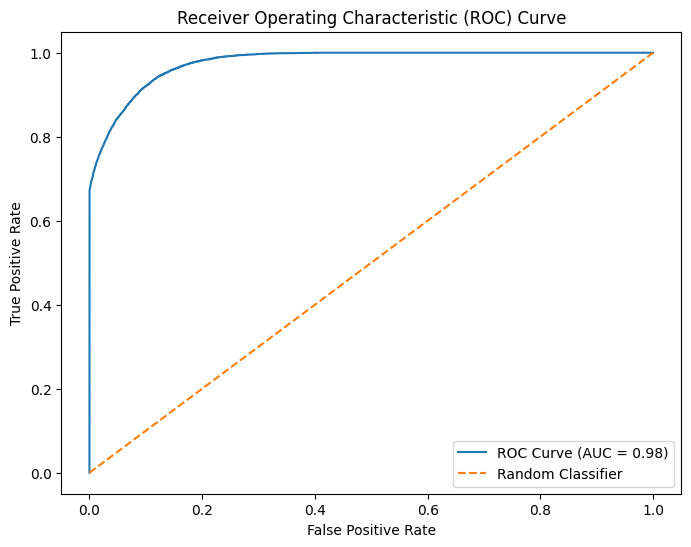

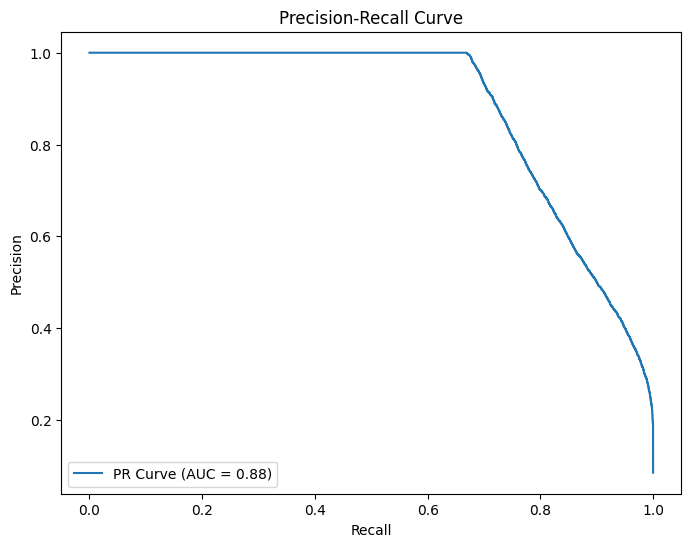

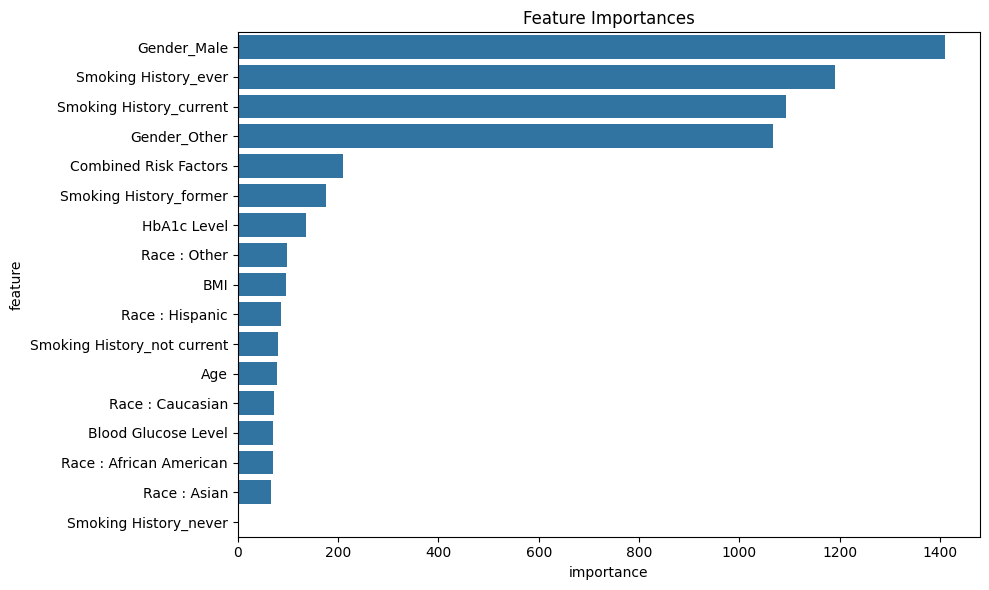

Model Evaluation Results:
--------------------------

Confusion Matrix:
[[91148   338]
 [ 2589  5911]]

Matthews Correlation Coefficient: 0.79699
PR AUC: 0.87972
ROC AUC: 0.97780
Recall : 0.69541

Feature Importances:
Gender_Male: 1409.00000
Smoking History_ever: 1190.00000
Smoking History_current: 1093.00000
Gender_Other: 1067.00000
Combined Risk Factors: 209.00000
Smoking History_former: 177.00000
HbA1c Level: 137.00000
Race : Other: 99.00000
BMI: 97.00000
Race : Hispanic: 86.00000
Smoking History_not current: 80.00000
Age: 78.00000
Race : Caucasian: 72.00000
Blood Glucose Level: 70.00000
Race : African American: 70.00000
Race : Asian: 66.00000
Smoking History_never: 0.00000


In [80]:

X = df.drop(columns='Diabetes', axis=1)
y = df['Diabetes']

 # List of features you want to keep
features_to_keep = [
        'Gender', 'Age', 'Race : African American', 'Race : Asian', 'Race : Caucasian', 
        'Race : Hispanic', 'Race : Other', 'Smoking History', 'BMI', 'HbA1c Level', 
        'Blood Glucose Level', 'Combined Risk Factors'
    ]

# Drop features not in the list
X = X[features_to_keep]

def display_results(results):
    print("Model Evaluation Results:")
    print("--------------------------")
    
    print("\nConfusion Matrix:")
    print(results['confusion_matrix'])
    
    print(f"\nMatthews Correlation Coefficient: {results['mcc']:.5f}")
    print(f"PR AUC: {results['pr_auc']:.5f}")
    print(f"ROC AUC: {results['roc_auc']:.5f}")
    print(f"Recall : {results['recall']:.5f}")
    
    print("\nFeature Importances:")
    # Combine feature names and importances, sort by importance, and display
    feature_imp = sorted(zip(results['feature_names'], results['feature_importance']), 
                         key=lambda x: x[1], reverse=True)
    for feature, importance in feature_imp:
        print(f"{feature}: {importance:.5f}")

# Usage
results = train_and_evaluate_lightgbm(X, y)
display_results(results)

In [81]:
df.columns

Index(['Year', 'Gender', 'Age', 'Location', 'Race : African American',
       'Race : Asian', 'Race : Caucasian', 'Race : Hispanic', 'Race : Other',
       'Hypertension', 'Heart Disease', 'Smoking History', 'BMI',
       'HbA1c Level', 'Blood Glucose Level', 'Diabetes',
       'Combined Risk Factors', 'BMI_Category', 'Blood_Glucose_Category',
       'HbA1c_Category', 'Cluster'],
      dtype='object')

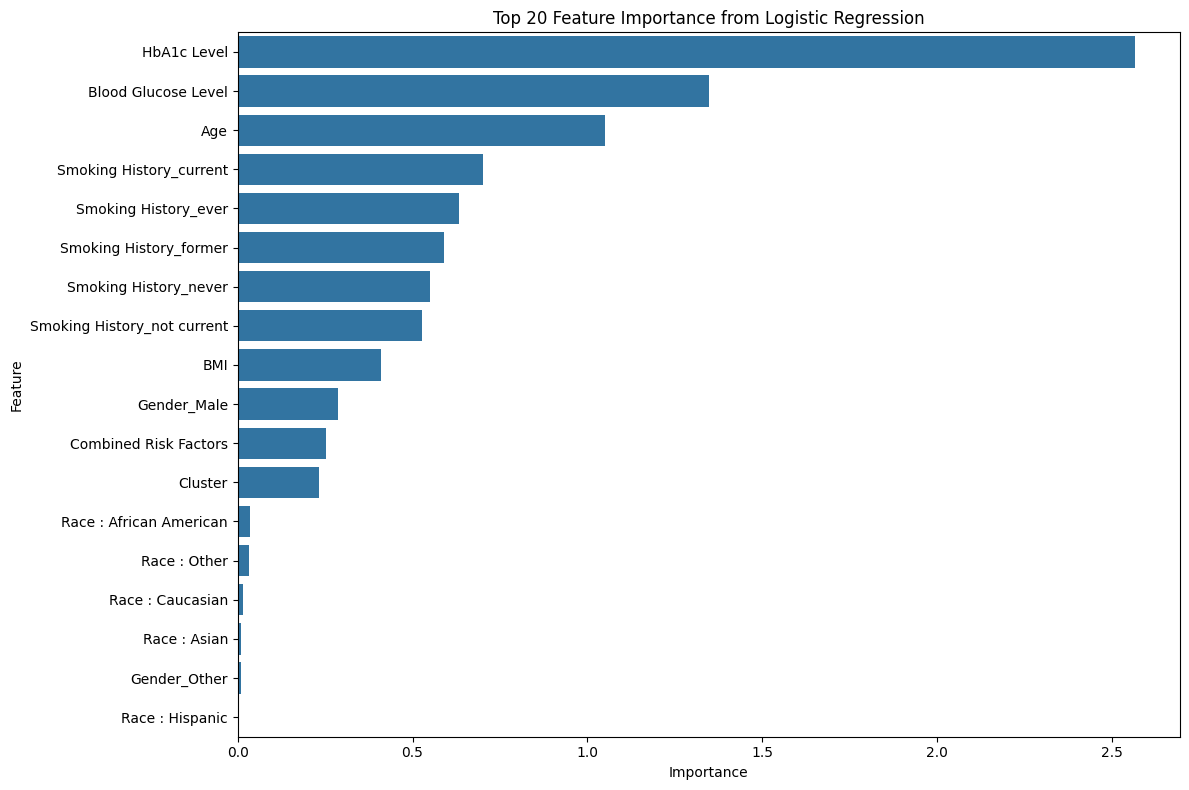

In [82]:
# Retesting LogRegression Model with current featureset

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy.stats import chi2_contingency

X = df.drop(columns=['Year', 'Location', 'Diabetes','Blood_Glucose_Category',
                     'BMI_Category','HbA1c_Category'], axis=1)

y = df['Diabetes']

# Separate numerical and categorical features
numerical_features = ['Age', 'BMI', 'HbA1c Level', 'Blood Glucose Level', 
                      'Race : African American', 'Race : Asian', 'Race : Caucasian', 
                      'Race : Hispanic', 'Race : Other', 
                      'Combined Risk Factors','Cluster']
categorical_features = ['Gender', 'Smoking History']


# Feature Importance from Logistic Regression
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ])

log_reg = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42))
])

log_reg.fit(X, y)

feature_names = (numerical_features + 
                 [f"{feature}_{category}" for feature, categories in 
                  zip(categorical_features, log_reg.named_steps['preprocessor']
                      .named_transformers_['cat'].categories_) 
                  for category in categories[1:]])

feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': np.abs(log_reg.named_steps['classifier'].coef_[0])
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
plt.title('Top 20 Feature Importance from Logistic Regression')
plt.tight_layout()
plt.show()

In [84]:
df.columns

Index(['Year', 'Gender', 'Age', 'Location', 'Race : African American',
       'Race : Asian', 'Race : Caucasian', 'Race : Hispanic', 'Race : Other',
       'Hypertension', 'Heart Disease', 'Smoking History', 'BMI',
       'HbA1c Level', 'Blood Glucose Level', 'Diabetes',
       'Combined Risk Factors', 'BMI_Category', 'Blood_Glucose_Category',
       'HbA1c_Category', 'Cluster'],
      dtype='object')

In [99]:
# Decision Tree with graphviz

y = df['Diabetes']
X = df.drop(columns=['Year', 'Location', 'BMI_Category', 'Blood_Glucose_Category', 'HbA1c_Category', 'Diabetes'])

# Identify categorical columns for one-hot encoding
categorical_columns = ['Gender', 'Smoking History']

# Create the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', X.select_dtypes(include=['int64', 'float64']).columns),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_columns)
    ])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=9)

# Fit the preprocessor and transform the data
X_train_encoded = preprocessor.fit_transform(X_train)
X_test_encoded = preprocessor.transform(X_test)

# Get feature names after preprocessing
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = [f"{col}_{val}" for col, vals in 
                        zip(categorical_columns, preprocessor.named_transformers_['cat'].categories_) 
                        for val in vals[1:]]
feature_names = numeric_features + categorical_features

# Create and train the model
tree_model = DecisionTreeClassifier(max_depth = 7,
                               min_samples_split = 10, 
                               min_samples_leaf = 5,
                               random_state=9,
                               class_weight = {0: 0.5464, 1: 5.8824})
tree_model.fit(X_train_encoded, y_train)

# Make predictions
y_pred = tree_model.predict(X_test_encoded)
y_pred_proba = tree_model.predict_proba(X_test_encoded)[:, 1]

# Calculate metrics
acc_score = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy Score: {acc_score:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Matthews Correlation Coefficient: {mcc:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

# Graph the Decision Tree

import pydotplus
from IPython.display import Image

# Create DOT data
dot_data = export_graphviz(
    model, out_file=None, feature_names=feature_names, class_names=["0", "1"],
    filled=True
)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)

# Show graph
Image(graph.create_png())

# Save the tree as PDF
file_path = "decision_tree.pdf"
graph.write_pdf(file_path)




Accuracy Score: 0.9137
Confusion Matrix:
[[20935  1901]
 [  256  1905]]
Matthews Correlation Coefficient: 0.6244
ROC AUC Score: 0.9736


True

Feature ranking:
1. feature 9 (0.499752)
2. feature 10 (0.349127)
3. feature 0 (0.109669)
4. feature 12 (0.017414)
5. feature 8 (0.013323)
6. feature 11 (0.010715)
7. feature 1 (0.000000)
8. feature 6 (0.000000)
9. feature 2 (0.000000)
10. feature 3 (0.000000)
11. feature 4 (0.000000)
12. feature 5 (0.000000)
13. feature 16 (0.000000)
14. feature 7 (0.000000)
15. feature 15 (0.000000)


Tune the hyperparameters on our two best models so far 
create a new scoring df to evaluate
pull the best scores for our two models before hyperparameter tuning to compare
include functions for saving the best features into a list for both models
that we're parameter tuning


In [55]:


def tune_lightgbm(X, y, n_iter=10, cv=5, n_jobs=-1):

   

    # Define feature sets
    features_to_scale = ['Age', 'BMI', 'HbA1c Level', 'Blood Glucose Level']
    features_to_onehot = ['Gender', 'Smoking History']
    

    # Create preprocessor
    preprocessor = ColumnTransformer([
        ('scaler', StandardScaler(), features_to_scale),
        ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), features_to_onehot)
    ], remainder='passthrough')

    # Define LightGBM model
    lgb_model = LGBMClassifier(random_state=42)

    # Define hyperparameter space
    param_dist = {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__learning_rate': [0.01, 0.05, 0.1],
        'classifier__num_leaves': [31, 63, 127],
        'classifier__max_depth': [-1, 5, 10],
        'classifier__min_data_in_leaf': [10, 20, 30, 50],
        'classifier__min_gain_to_split': [0, 0.1, 0.2, 0.5]
        
    }

    # Create pipeline
    pipeline = ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', lgb_model)
    ])

    # Set up cross-validation
    cv_splitter = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    # Perform random search
    random_search = RandomizedSearchCV(
        pipeline, param_distributions=param_dist, n_iter=n_iter,
        scoring='balanced_accuracy', cv=cv_splitter, n_jobs=n_jobs,
        random_state=42, verbose=1
    )

    # Fit the model
    random_search.fit(X, y)

    # Get best model
    best_model = random_search.best_estimator_

    # Get feature importances
    feature_importance = best_model.named_steps['classifier'].feature_importances_
    
    # Calculate metrics on the entire dataset
    y_pred = best_model.predict(X)
    y_pred_proba = best_model.predict_proba(X)[:, 1]

    # Compile results
    results = {
        'best_params': random_search.best_params_,
        'feature_importance': feature_importance,
        'accuracy': accuracy_score(y, y_pred),
        'mcc': matthews_corrcoef(y, y_pred),
        'pr_auc': average_precision_score(y, y_pred_proba),
        'confusion_matrix': confusion_matrix(y, y_pred),
        'precision': precision_score(y, y_pred),
        'recall': recall_score(y, y_pred),
        'f1': f1_score(y, y_pred)
    }

    return best_model, results



In [56]:
# Call the Hyperparameter tuning function

X = df.drop(columns='Diabetes', axis=1)
y = df['Diabetes']

 # List of features you want to keep
features_to_keep = [
        'Gender', 'Age', 'Race : African American', 'Race : Asian', 'Race : Caucasian', 
        'Race : Hispanic', 'Race : Other', 'Smoking History', 'BMI', 'HbA1c Level', 
        'Blood Glucose Level', 'Combined Risk Factors'
    ]

# Drop features not in the list
X = X[features_to_keep]


best_model, results = tune_lightgbm(X, y, n_iter=20, cv=5)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Info] Number of positive: 91486, number of negative: 91486
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 182972, number of used features: 16
[LightGBM] [Info] [binary:Boo

In [57]:
results

{'best_params': {'classifier__num_leaves': 31,
  'classifier__n_estimators': 200,
  'classifier__min_gain_to_split': 0,
  'classifier__min_data_in_leaf': 30,
  'classifier__max_depth': 10,
  'classifier__learning_rate': 0.01},
 'feature_importance': array([1060,  657, 1444, 2304,   49,    0,    0,    2,    7,   63,   32,
           0,   13,    0,    0,   13,  356]),
 'accuracy': 0.9449722961214571,
 'mcc': 0.6966465067375133,
 'pr_auc': 0.8778197262103116,
 'confusion_matrix': array([[87442,  4044],
        [ 1458,  7042]], dtype=int64),
 'precision': 0.6352155872271333,
 'recall': 0.8284705882352941,
 'f1': 0.7190850607576841}